# Use super-resolution to retrieve high-resolution salinity - Data description 

## History

* 6/29/2024
  * Upload the description of the new global data saved in shared-public/swot_shared/super_resolution/SSS
  * Add the utils.py for loading the new data.

In [1]:
import earthaccess
import pylab as plt 
import xarray as xr
import requests

## Global SSS data - added on 6/29/2024

1. Load data from /home/jovyan/shared-public/swot_shared/super_resolution/SSS/. Each file contains the sea surface salinity from a 1/48-degree MITgcm simulation. "shrunk" means that the zero values of the model grid over continents are maually removed to save disk. We need the mask information stored in /home/jovyan/shared-public/swot_shared/super_resolution/SSS/hFacC_k0.data. hfacc!=0 corresponds to 'wet' cells. Fill those wet cells using the shrunk file will restore the complete original model field. Use the function mds2d in utils.py to map the data to rwo 2D fields. 

In [12]:
import numpy as np
import utils 

sss=np.fromfile('/home/jovyan/shared-public/swot_shared/super_resolution/SSS/hFacC_k0.data','>f4')
sss_tmp=np.fromfile('/home/jovyan/shared-public/swot_shared/super_resolution/SSS/SSS.0001400112.shrunk','>f4')
sss[sss!=0]=sss_tmp
sss[sss==0]=np.nan

sss_east,sss_west=utils.mds2d(sss)
print(sss_east.shape,sss_west.shape)

(12960, 8640) (8640, 12960)


Text(0.5, 1.0, 'tiles 1-6 + 8-13')

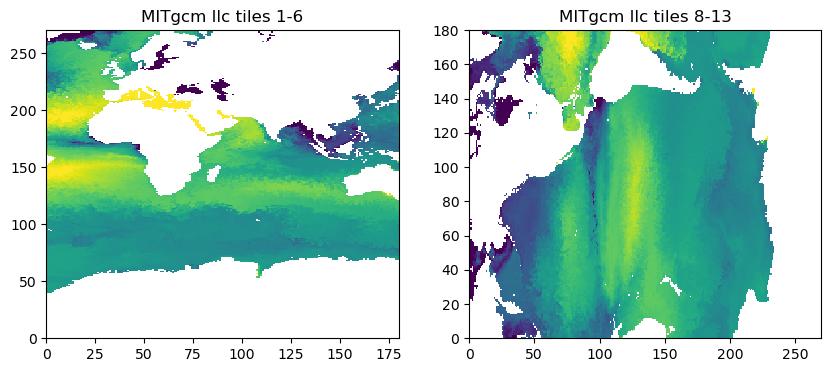

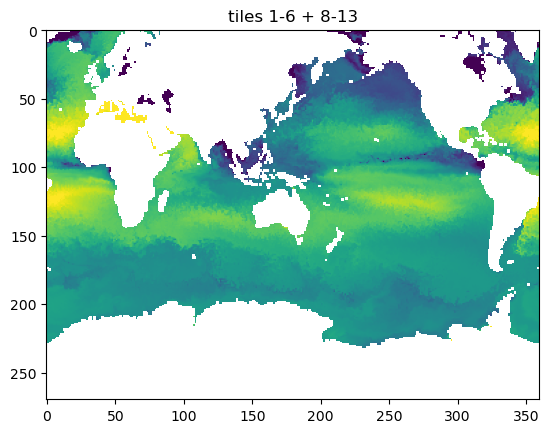

In [28]:
#show an example
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].pcolormesh(sss_east[::48,::48],vmin=31,vmax=37) #skip every 48 points to speed up the image rendering
ax[0].set_title('MITgcm llc tiles 1-6')
#ax[0].invert_yaxis() 
ax[1].pcolormesh(sss_west[::48,::48],vmin=31,vmax=37) #skip every 48 points to speed up the image rendering
ax[1].set_title('MITgcm llc tiles 8-13')
sss_full=np.c_[sss_east,sss_west.T[::-1,:]] #piece the two together

plt.figure()
plt.imshow(sss_full[::48,::48][::-1,:],vmin=31,vmax=37)
plt.title('tiles 1-6 + 8-13')

### Generate small stampes

* The size of each stamp is specificed by ndegree


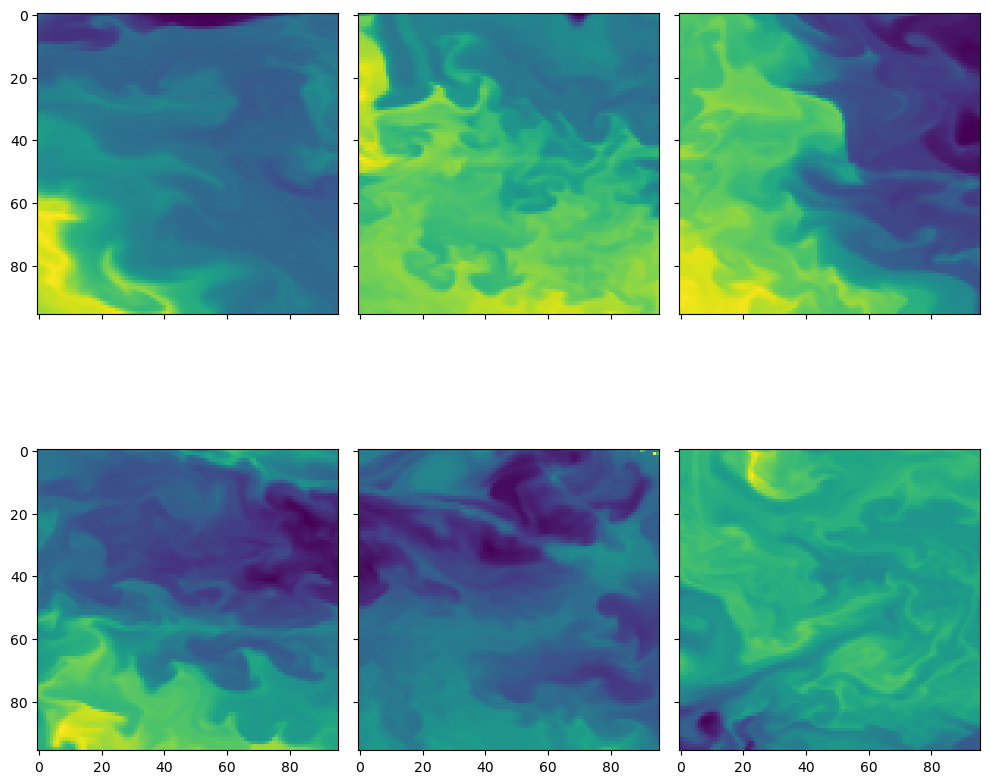

In [35]:
ndegree=2 #2-degree stampe
ngrid=ndegree*48 
ny,nx=sss_full.shape
ny_n=ny//ngrid
nx_n=nx//ngrid

sss_reshape=np.swapaxes(sss_full.reshape(ny_n,ngrid,nx_n,ngrid),1,2).reshape(ny_n*nx_n,ngrid,ngrid) #reshape the global data to ny_n*nx_n stamps each of which has ngrid x ngrid shape
# Find the regions that has no land (nan) values
msk=np.isfinite(sss_reshape.mean(axis=-1).mean(axis=-1))
sss_stamps=sss_reshape[msk,...]

fig,ax=plt.subplots(2,3,figsize=(10,10),sharex=True,sharey=True)

for i,ax in enumerate(ax.flatten()):
    ax.imshow(sss_stamps[i,...])
plt.tight_layout()    

### Reduce the resolution

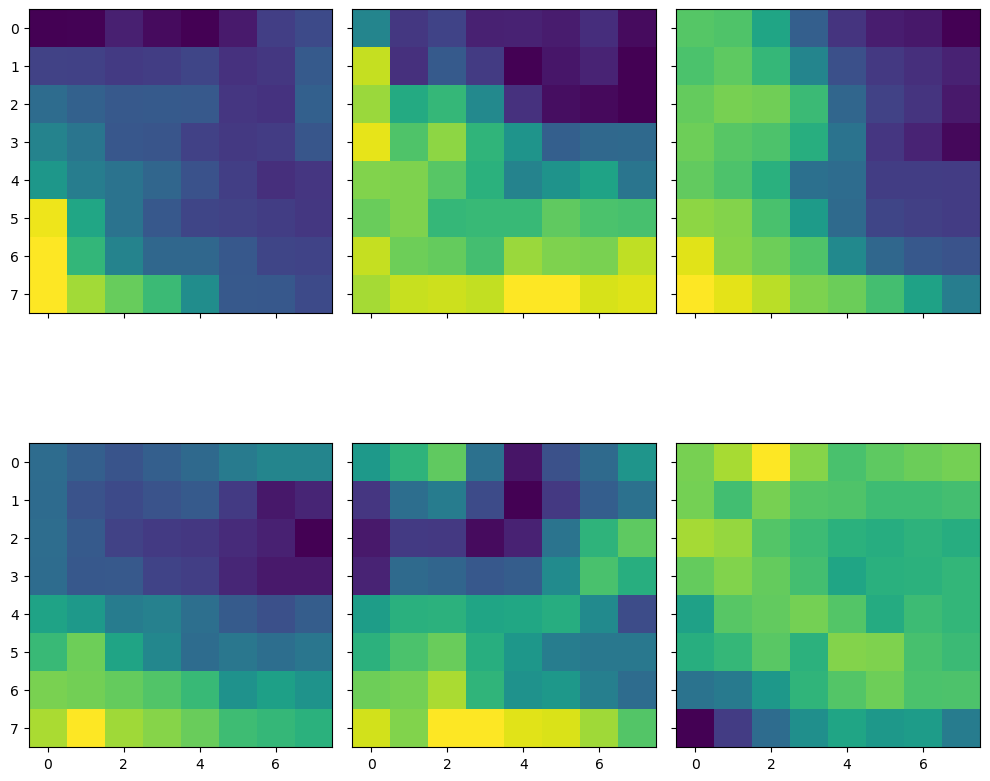

In [36]:
# Target resolution
target_resolution=0.25 #degrees
n=int(48*target_resolution)
m=int(ndegree/target_resolution)

fig,ax=plt.subplots(2,3,figsize=(10,10),sharex=True,sharey=True)

for i,ax in enumerate(ax.flatten()):
    ax.imshow(sss_stamps[i,...].reshape(m,n,m,n).mean(axis=-1).mean(axis=1))
plt.tight_layout()    

## The following was for a regional test

In [4]:
earthaccess.login()
results = earthaccess.search_data(
    short_name='MITgcm_LLC4320_Pre-SWOT_JPL_L4_CapeBasin_v1.0',
    count=1000
)

Granules found: 429


In [6]:
files = earthaccess.download(results[:1], "./local_folder")

 Getting 1 granules, approx download size: 1.44 GB
Accessing cloud dataset using dataset endpoint credentials: https://archive.podaac.earthdata.nasa.gov/s3credentials
Downloaded: local_folder/LLC4320_pre-SWOT_CapeBasin_20110913.nc


In [7]:
data=xr.open_dataset('local_folder/LLC4320_pre-SWOT_CapeBasin_20110913.nc')
display(data)

<xarray.Dataset> Size: 4GB
Dimensions:   (j_g: 282, i: 192, i_g: 192, j: 282, k: 88, k_u: 88, k_l: 88,
               k_p1: 89, nb: 2, time: 24)
Coordinates:
  * j_g       (j_g) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 278.0 279.0 280.0 281.0
  * i         (i) float32 768B 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 768B 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 278.0 279.0 280.0 281.0
  * k         (k) int32 352B 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87
  * k_u       (k_u) int32 352B 0 1 2 3 4 5 6 7 8 ... 79 80 81 82 83 84 85 86 87
  * k_l       (k_l) int32 352B 0 1 2 3 4 5 6 7 8 ... 79 80 81 82 83 84 85 86 87
  * k_p1      (k_p1) int32 356B 0 1 2 3 4 5 6 7 8 ... 80 81 82 83 84 85 86 87 88
  * nb        (nb) int32 8B 0 1
  * time      (time) datetime64[ns] 192B 2011-09-13 ... 2011-09-13T23:00:00
Data variables: (12/33)
    XC        (j, i) float32 217kB ...
    YC        (j, i) float32 217kB ...
    DXV       (j, i) float32 217kB ...
    DYU       (j, i) float32 217kB ...
    Depth     (j, i) float32 217kB ...
    DXC       (j, i_g) float32 217kB ...
    ...        ...
    oceTAUY   (time, j_g, i) float64 10MB ...
    Theta     (time, k, j, i) float64 915MB ...
    Salt      (time, k, j, i) float64 915MB ...
    U         (time, k, j, i_g) float32 457MB ...
    V         (time, k, j_g, i) float64 915MB ...
    W         (time, k_l, j, i) float64 915MB ...
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2011-09-13 23:00:00
    time_coverage_start:             2011-09-13 00:00:00
    title:                           LLC4320 regional Cape Basin
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

## Origional high-resolution sea surface fields 

Text(0, 0.5, '/cycle/km')

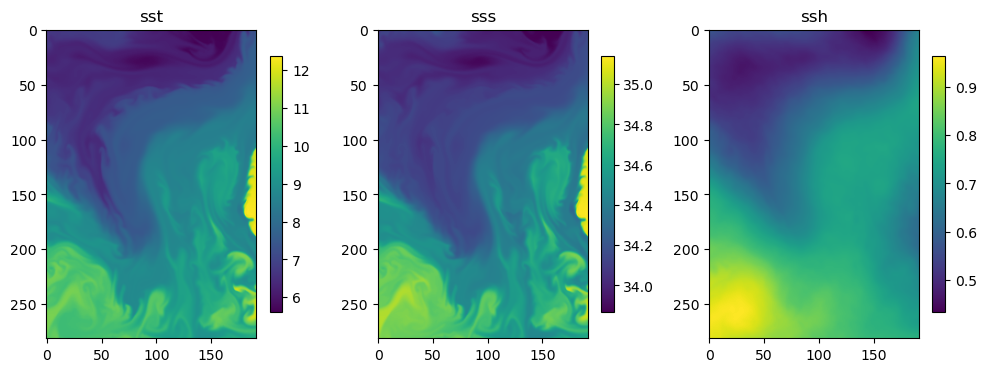

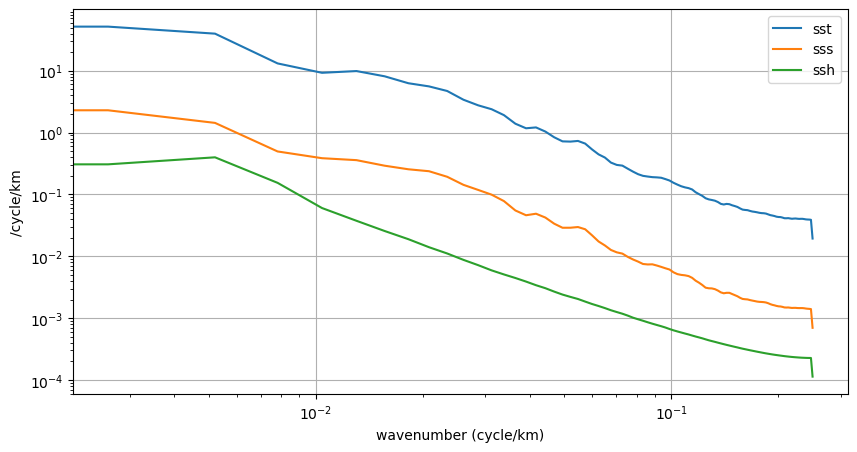

In [72]:
fig,axs=plt.subplots(1,3,figsize=(10,4)) 

def spectrum(data, dx=2): 
    from scipy.signal import welch 
    nj,ni=data.shape
    f,a=welch(data.flatten(),nfft=ni, nperseg=ni,
              window='hann',fs=1/dx,detrend='linear')

    return f,a

datain={}
datain['sst']=data['Theta'][0,0,...]
datain['sss']=data['Salt'][0,0,...]
datain['ssh']=data['Eta'][0,...]

for ax, var in zip(axs,datain.keys()): 
    cb=ax.imshow(datain[var].data)
    plt.colorbar(cb,shrink=0.7)
    ax.set_title(var)

plt.tight_layout()

plt.figure(figsize=(10,5))
for var in datain.keys():
    f,a=spectrum(datain[var].data)
    plt.loglog(f,a,label=var)
plt.legend()
plt.grid(True)
plt.xlabel('wavenumber (cycle/km)')
plt.ylabel('/cycle/km')

## Create low-resolution synthetic data

(282, 192)


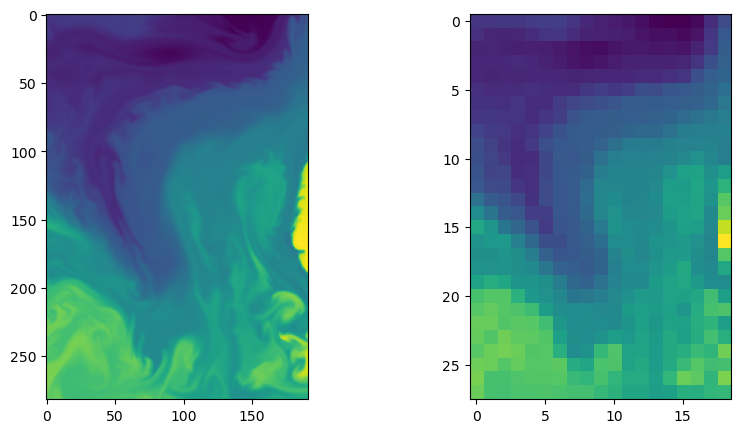

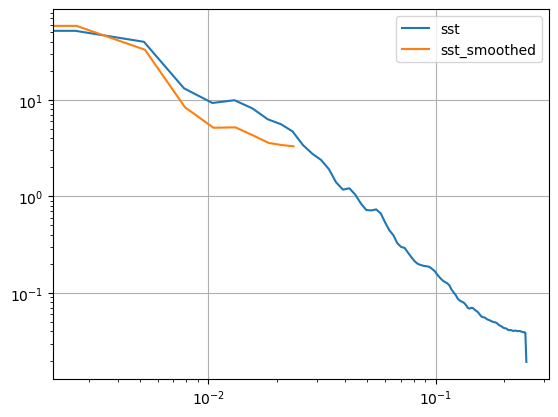

In [73]:
from scipy import signal 
import numpy as np

print(datain['sst'].shape)

sst_smoothed=datain['sst'][:280,:190].data.reshape(28,10,19,10).mean(axis=1).mean(axis=-1) #box-average over 10-grid points (~20km)

fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(datain['sst'].data)
ax[1].imshow(sst_smoothed)

plt.figure()
f,a=spectrum(datain['sst'].data)
plt.loglog(f,a,label='sst')
f,a=spectrum(sst_smoothed,20)
plt.loglog(f,a,label='sst_smoothed')

plt.legend()
plt.grid(True)